In [3]:
cuda_lib_path = "/usr/local/cuda-10.2/targets/x86_64-linux/lib:/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder/targets/x86_64-linux/lib"
os.environ["LD_LIBRARY_PATH"] = cuda_lib_path + ":" + os.environ.get("LD_LIBRARY_PATH", "")

LD_LIBRARY_PATH: /usr/local/cuda-10.2/targets/x86_64-linux/lib:/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder/targets/x86_64-linux/lib::


A
Bottom-up:  484 484 484
synapses s1
synapses_1 s2


WARNING    'i' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO:root:creating /tmp/brian_flag_test_c_gsmhcr/tmp/brian_flag_test_c_gsmhcr
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_c_gsmhcr/flag_test.cpp -o /tmp/brian_flag_test_c_gsmhcr/tmp/brian_flag_test_c_gsmhcr/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_9449_r30/tmp/brian_flag_test_9449_r30
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_9449_r30/flag_test.cpp -o /tmp/brian_flag_test_9449_r30/tmp/brian_flag_test_9449_r30/flag_test.o -O3
INFO:root:creating /tmp/brian_f

spikemonitor
spikemonitor_1
spikemonitor_2
spikemonitor_3
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


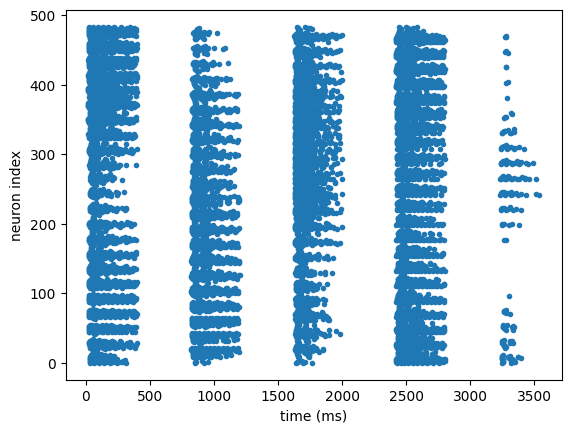

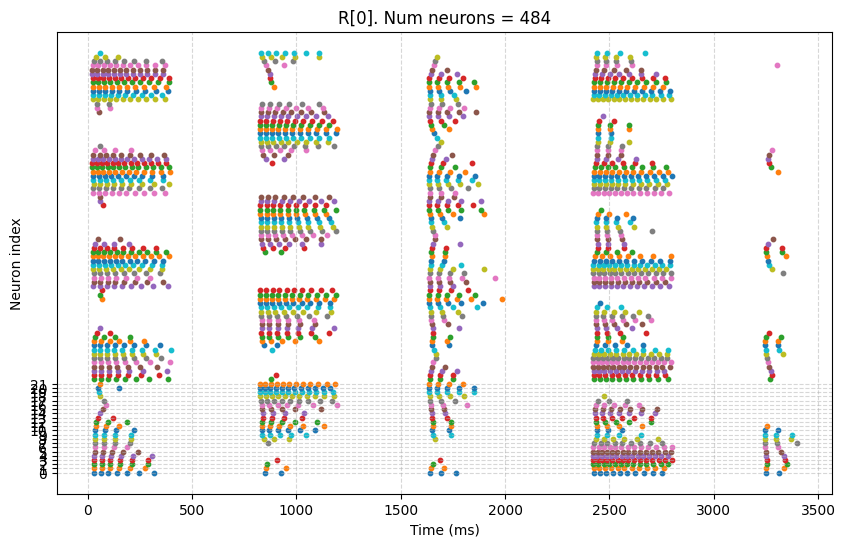

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')


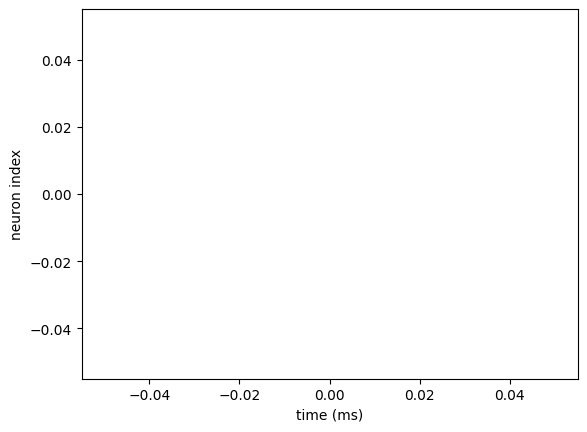

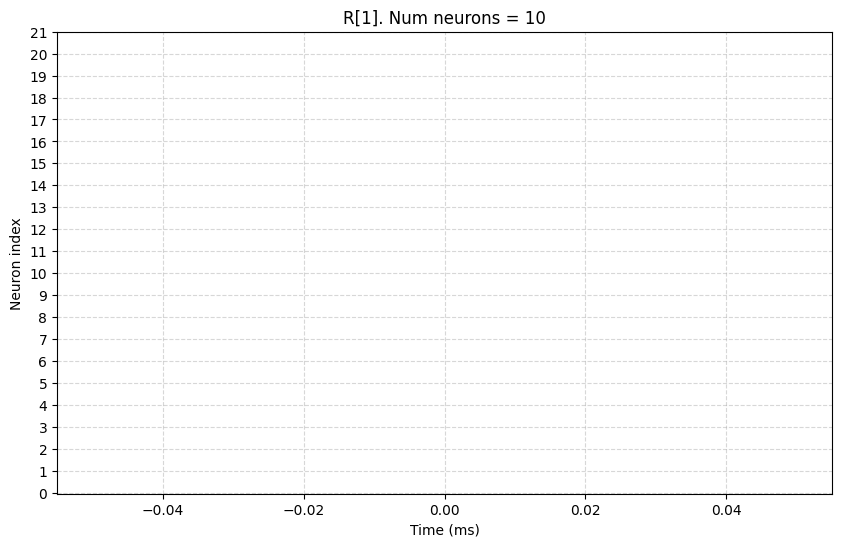

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')


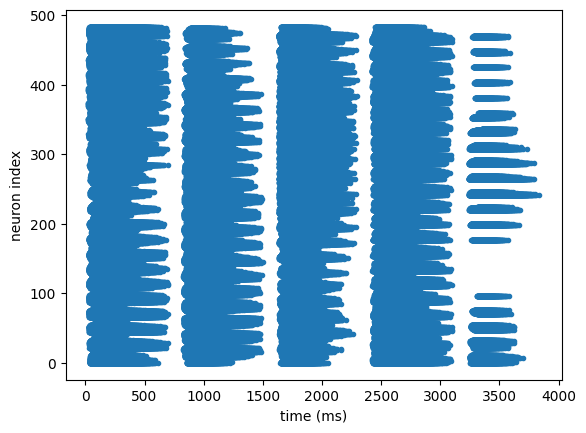

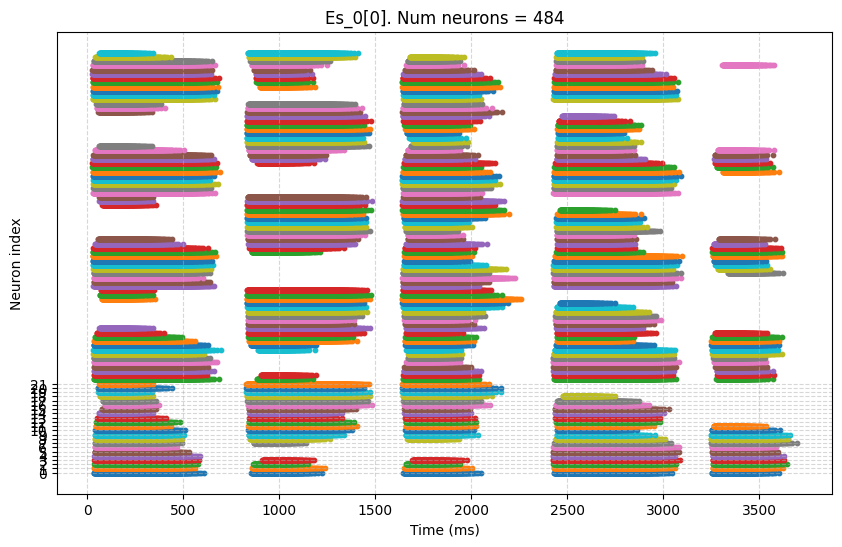

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


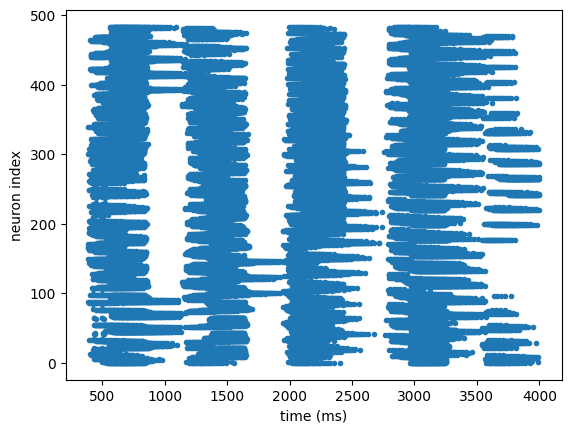

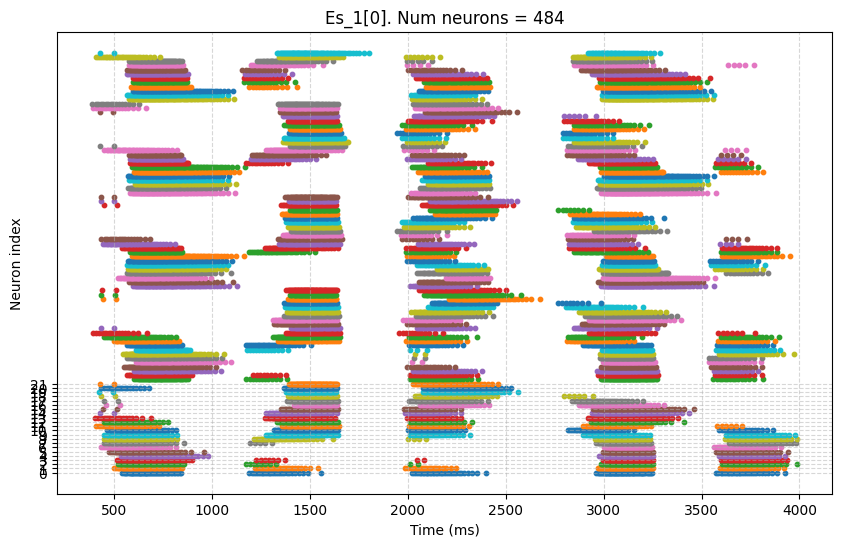

In [1]:
import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

import brian2cuda
from brian2cuda import *

import brian2tools as b2t


set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()


#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone


prefs.devices.cuda_standalone.cuda_backend.cuda_runtime_version = (12.2)
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
# prefs.devices.cuda_standalone.cuda_backend.cuda_path = '/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder'



# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 400 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -45.4 * mV  # Spike threshold

DeltaT = 5 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 300 * ms  # Adaptation time constant
c = 10 * nS       # Coupling parameter
b = 1.805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nsiemens   # Initial synaptic weight (conductance)

regularizer = 10 * nvolt


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : volt   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, i) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc_internal : amp  # Synaptic input
I_tot = Iexc + Iexc_internal + output_stimuli(t, i) : amp
indices : integer  # dimensionless index variable
spike_count = 0 : integer
batch_sum_X : volt
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance

Iexc_post = w * X_post : amp (summed)
'''

syn_eqs_exc_2 = '''
w : siemens   # Synaptic weight, conductance

Iexc_2_post = w * X_post : amp (summed)
'''

syn_eqs_exc_3 = '''
w : siemens

Iexc_3_post = w * X_post : amp (summed)
'''

syn_eqs_exc_4 = '''
w : siemens

Iexc_4_post = w * X_post : amp (summed)
'''


syn_eqs_exc_output = '''
w : siemens   # Synaptic weight, conductance

Iexc_internal_post = w * X_post  : amp (summed)
'''



syn_eqs_inh= '''
w : siemens   # Synaptic weight, conductance

Iinh_post = w * -X_post  : amp (summed)
'''

syn_eqs_inh_2= '''
w : siemens   # Synaptic weight, conductance

Iinh_2_post = w * -X_post  : amp (summed)
'''

syn_eqs_inh_3= '''
w : siemens   # Synaptic weight, conductance

Iinh_3_post = w * -X_post  : amp (summed)
'''

syn_eqs_inh_4= '''
w : siemens   # Synaptic weight, conductance

Iinh_4_post = w * -X_post  : amp (summed)
'''






###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     
def manual_fully_connect(syn, N_pre, N_post):
    # Manually specify connections
    pre_indices = [i for i in range(N_pre) for _ in range(N_post)]
    post_indices = [j for _ in range(N_pre) for j in range(N_post)]

    # Connect manually
    syn.connect(i=pre_indices, j=post_indices) 
    
    return syn  
            

def make_bottom_up_connections(R, E_0, E_1):
    print("A")
    print("Bottom-up: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(R, E_0, model=syn_eqs_exc, on_pre='Y_post = 10*volt', custom_name = "s1")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(R, E_1, model=syn_eqs_inh, on_pre='Y_post = 10*volt', custom_name = "s2")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m

def make_bottom_up_connections_2(E_0, E_1,R):
    print("B")
    print("Bottom-up-2: ", R.N, E_0.N, E_1.N )
    S_p = NamedSynapses(E_0, R, model=syn_eqs_inh_2, on_pre='Y_post = 10*volt', custom_name = "s3")
    S_p.connect(j='i')
    S_p.w = 'w_init'

    S_m = NamedSynapses(E_1, R,  model=syn_eqs_exc_2, on_pre='Y_post = 10*volt', custom_name = "s4")
    S_m.connect(j='i')
    S_m.w = 'w_init'

    return S_p, S_m





def make_network(dims, num_classes_per_layer, max_depth):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
   
    
    connections = {}
    for i in range(len(Rs)-1):
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i])

        if i != 0:
            S_p_2, S_m_2 = make_bottom_up_connections_2(Es_0[i], Es_1[i], Rs[i])
            connections[f"bottom_up_2_{i}"] = [S_p_2, S_m_2]
        connections[f"bottom_up_{i}"] = [S_p, S_m]
        
    
    return Rs, Es_0, Es_1, connections




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
N = 22
dims = [N*N,10]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs, Es_0, Es_1, connections = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500

tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)


lr = 0.03
batch_size = 20
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.3, 1.2)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=120
    )
)



torch.save(dataset, "data/dataset1.pt")

#dataset = torch.load("data/dataset1.pt")




def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation
    
    
@network_operation()
def update_sums():
    current_idx = int(defaultclock.t / msec_step)
    if stimulus_indexes.values[current_idx] == 1:
        for n in range(len(Rs)-1):
            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X
            Es_0[n].batch_sum_X += Es_0[n].X
            Es_1[n].batch_sum_X += Es_1[n].X
            

            


def if_positive(x, w):
    # Return x where w > 0, otherwise 0 (element-wise)
    return np.where(w > 0, x, 0 * volt)
    
    
@network_operation()
def apply_weight_update():
    print("Applying weight update")
    for n in range(len(Rs)-1):
        
        print("n: ", n)
        
        # Retrieve top_down synapses       
        S_p, S_m = connections[f"top_down_{n}"]
        S_p_2, S_m_2 = connections[f"top_down_2_{n}"]
        
        
        
        
            
        for j_idx in range(Es_0[n].N):
            for i_idx in range(Rs[n+1].N):
                
                positive_connections_delta = lr * volt * Es_0[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] - if_positive(regularizer, S_p.w_[i_idx, j_idx])
                negative_connections_delta = lr * volt * Es_1[n].batch_sum_X[j_idx] * Rs[n+1].batch_sum_X[i_idx] - if_positive(regularizer, S_m.w_[i_idx, j_idx])
                
                S_p.w[i_idx, j_idx] += positive_connections_delta_ * siemens
                S_m.w[i_idx, j_idx] -= negative_connections_delta_ * siemens
                
                S_p_2.w[i_idx, j_idx] += positive_connections_delta_ * siemens
                S_m_2.w[i_idx, j_idx] -= negative_connections_delta_ * siemens
                
     
            # Reset after update
            Rs[n+1].batch_sum_X[:] = 0 * volt
            Es_0[n].batch_sum_X[:] = 0 * volt
            Es_1[n].batch_sum_X[:] = 0 * volt
    
    
    

    

            
            
    Rs[-1].batch_sum_X[:] = 0
  
        
            
            
     
# Extract all synapses and objects for the network
all_synapses = []
# all_synapses.append(S_o_internal)

for i in range(len(Rs)-1):
    bu_syns = connections[f"bottom_up_{i}"]
    all_synapses.extend(bu_syns)
   

for i in range(1,len(Rs)-1):
    bu_syns = connections[f"bottom_up_2_{i}"]
    all_synapses.extend(bu_syns)
 





s = 0

        







# Add spike monitors for all neuron groups



stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

net = Network(
    Rs, Es_0, Es_1,       
    update_sums, apply_weight_update # Additional operations
)

for i in range(len(Rs)):
    net.add(NamedSpikeMonitor(Rs[i], record=True, custom_name = f"R[{i}]"))
    if i > 0:
        net.add(NamedSpikeMonitor(Es_0[i-1], record=True, custom_name = f"Es_0[{i-1}]"))
        net.add(NamedSpikeMonitor(Es_1[i-1], record=True, custom_name = f"Es_1[{i-1}]"))

for synapse in all_synapses:
    net.add(synapse)

all_batch_rates = []
output_spikes = []

s = 0

#stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

#net.stimulus_indexes = stimulus_indexes
#net.output_stimuli   = output_stimuli
#net.input_stimuli    = input_stimuli

run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)
result_dir = f'results_v2'
device.build(run=True, directory="project_v2",results_directory=result_dir) 

# device.build(directory='project', run = False)

states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)
        
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    
    b2t.brian_plot(spike_mon_o)
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    


Num input neurons:  NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


INFO:root:creating /tmp/brian_flag_test_328lem9x/tmp/brian_flag_test_328lem9x
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_328lem9x/flag_test.cpp -o /tmp/brian_flag_test_328lem9x/tmp/brian_flag_test_328lem9x/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_2a5kkg_v/tmp/brian_flag_test_2a5kkg_v
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/brian_flag_test_2a5kkg_v/flag_test.cpp -o /tmp/brian_flag_test_2a5kkg_v/tmp/brian_flag_test_2a5kkg_v/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test_0_hh2ndc/tmp/brian_flag_test_0_hh2ndc
INFO:root:x86_64-linux-gnu-g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwr

spikemonitor
NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


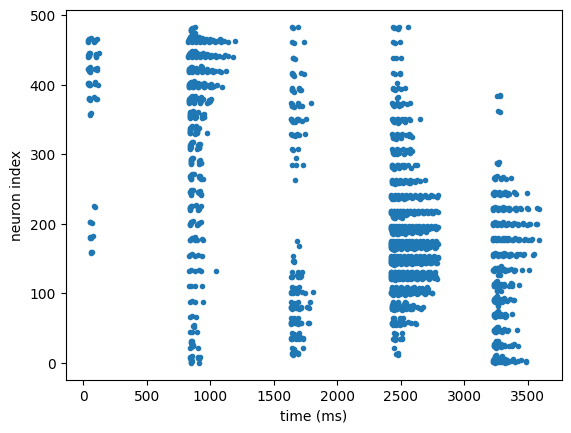

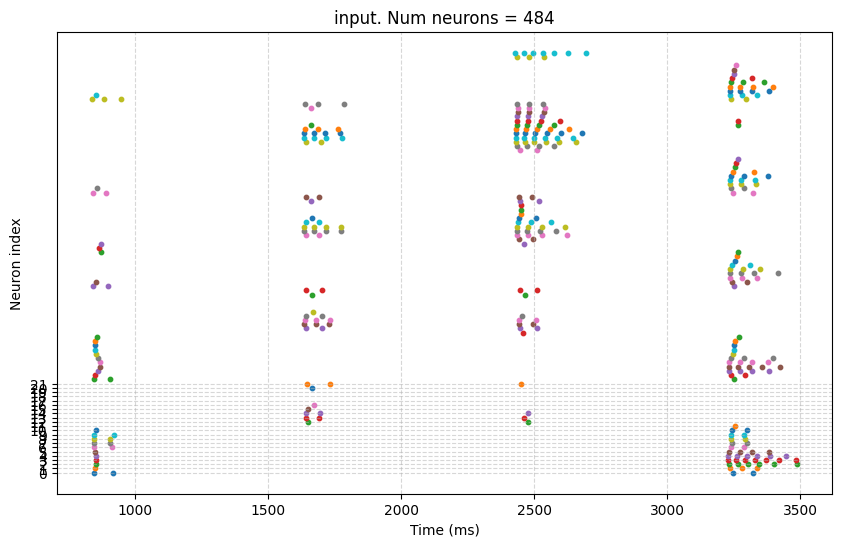

In [1]:

import os

import time
import torch
import datetime
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import numpy as np

from dataset_util import Synthetic_Dataset_Utils




from brian2 import prefs
#from brian2 import set_device
from brian2.devices import device_module

import brian2cuda
from brian2cuda import *

import brian2tools as b2t


set_device("cpp_standalone", directory='project', build_on_run=False)

device = b2.get_device()


#set_device("cuda_standalone", build_on_run=True)
# Set specific preferences for CUDA standalone


prefs.devices.cuda_standalone.cuda_backend.cuda_runtime_version = (12.2)
prefs.devices.cuda_standalone.profile_statemonitor_copy_to_host = None
prefs.devices.cuda_standalone.cuda_backend.extra_compile_args_nvcc = ['-use_fast_math', '-w']
prefs.devices.cuda_standalone.cuda_backend.detect_gpus = True
prefs.devices.cuda_standalone.cuda_backend.gpu_id = 0  # Use the first GPU
# prefs.devices.cuda_standalone.cuda_backend.cuda_path = '/home/brovoletto/SerotoninSNN/nvcc_installation/nvcc_folder'



# REMEMBER YOU SWITCHED SOME EXCITATORY WITH INHIBITORY!!!!!!!!


###############################################################################
# Model Parameters and Equations
###############################################################################
msec_step = 400 * ms

# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# TODO: Make weights always non-negative! (maybe not necessary)
# Equations for everything. I_post in the synapse is modifying I in the target neuron




# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -45.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 300 * ms  # Adaptation time constant
c = 10 * nS       # Coupling parameter
b = 1.805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nsiemens   # Initial synaptic weight (conductance)

regularizer = 10 * nvolt


# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iexc_2 + Iexc_3 + Iexc_4 + Iinh + Iinh_2 + Iinh_3 + Iinh_4 - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp
Iexc_2 : amp
Iexc_3 : amp
Iexc_4 : amp
Iinh : amp
Iinh_2 : amp
Iinh_3 : amp
Iinh_4 : amp
batch_sum_X : volt   # Accumulate X values over a batch

'''
# Ii = I + input_stimuli(t)  :  amp  # Input current


input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, i) : amp
indices : integer
'''







###############################################################################
# Helper Functions
###############################################################################
def make_groups(dims, eqs=eqs, with_input=False):
    groups = []
    for i, dim in enumerate(dims):
        if i == 0 and with_input:
            g = NeuronGroup(dim, input_eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        else:
            g = NeuronGroup(dim, eqs, threshold='v > -40*mV', reset='v = Vr', method='euler')
        g.v = EL
        groups.append(g)
    return groups


class NamedSynapses(Synapses):
    def __init__(self, source, target=None, model=None, custom_name=None, **kwargs):
        super().__init__(source, target, model, **kwargs)
        
        self.add_attribute("brian2_name")
        self.add_attribute("custom_name")
        
        self.brian2_name = self.name  
        
        self.custom_name = custom_name or f"{source}-{target}"
        
        print(self.brian2_name, self.custom_name)
        
    def connect(self, **kwargs):
        # Call the original connect method
        super().connect(**kwargs)
        if self.custom_name == "suygu5":
            # Print the connections
            connections = [(i, j) for i, j in zip(self.i[:], self.j[:])]
            print("Connections created:")
            for pre, post in connections:
                print(f"Pre: {pre}, Post: {post}")
            
        
        
class NamedSpikeMonitor(SpikeMonitor):
    def __init__(self, group, custom_name=None, **kwargs):
        super().__init__(group, **kwargs)
        self.add_attribute("custom_name")
        self.custom_name = custom_name or str(group)    
     
     
     



def make_network(dims, num_classes_per_layer, max_depth):
    max_depth += 1
    Rs = make_groups(dims, with_input=True)
    
    
    return Rs




def normalize_tensor(tensor, old_min, old_max, new_min, new_max):
    normalized_tensor = (tensor - old_min) / (old_max - old_min)
    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min
    return scaled_tensor




def normalize_and_unwrap_dataset(dt, minval, maxval):
    minimum = 0
    maximum = 0
    all_curves = [torch.tensor(curve, dtype=torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    for curve in all_curves:
        _min = torch.min(curve)
        _max = torch.max(curve)
        if (minimum > _min): minimum = _min
        if (maximum < _max): maximum = _max

    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
    return unwrapped



def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):
    if labels.ndim == 1:
        labels = labels.unsqueeze(0)

    indexes = torch.zeros_like(labels)
    for i in range(labels.shape[1]):
        summed = 0
        if i > 0:
            summed = torch.stack([labels[:, j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
        indexes[:, i] = summed + labels[:, i]

    # Adjust indexes for concatenation
    to_sum = 0
    for i in range(labels.shape[1]):
        if i > 0:
            to_sum += num_classes_per_layer**i
        indexes[:, i] = indexes[:, i] + to_sum
    return indexes

def get_output_current_arrays(I_indexes, dim, I_value):
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)

    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])
    col_indices = I_indexes.flatten()
    out[row_indices, col_indices] = I_value
    return out

class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels, curves = self.data[idx]
        return labels, curves.flatten()

def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):
    labels, curves = zip(*batch)
    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)

    pause = torch.zeros_like(curves[0])
    pause_block = torch.tile(pause, (num_pause_blocks, 1))
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])
    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step)

    stimulus_indexes = TimedArray(np.tile([1] + [0] * num_pause_blocks, curves.size(0)), dt=msec_step)

    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)
    label_pause = torch.zeros(out_dim)
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1))
    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])
    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step)

    return stimulus_indexes, output_stimuli, visual_stimulus

###############################################################################
# Build the network and run
###############################################################################
#dims = [22*22, 250, 125, 64]
dims = [22*22,10,10]
num_classes_per_layer = 3
max_depth = 3

# Rs, Es_0, Es_1, G, Os, S_o_internal, connections = make_network(dims, num_classes_per_layer, max_depth)
Rs = make_network(dims, num_classes_per_layer, max_depth)

Rs[0].indices = range(Rs[0].N)

su = Synthetic_Dataset_Utils()
ranges = [30, 30, 30, 30]
prior_params = [10, 10, 10, 10]
num_samples_per_class = 500
N = 22
tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, 1, ranges)
synth_dataset = su.make_dataset(tree, num_classes_per_layer, num_samples_per_class=num_samples_per_class, N=N)


lr = 0.03
batch_size = 20
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.3, 1.2)
dl = DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=partial(
        collate_fn,
        msec_step=msec_step,
        num_pause_blocks=num_pause_blocks,
        num_classes_per_layer=num_classes_per_layer,
        out_dim=39
    )
)

    
            




monitor_o = StateMonitor(Rs[0], ['v', 'I', 'X'], record=True)
spike_mon_o = NamedSpikeMonitor(Rs[0], record = True, custom_name = "input")

print("Num input neurons: ", Rs[0])

# Add spike monitors for all neuron groups


stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

net = Network(
    Rs,  # Neuron groups       
    monitor_o, spike_mon_o, # Output monitors
)



#stimulus_indexes, output_stimuli, input_stimuli = next(iter(dl))

#net.stimulus_indexes = stimulus_indexes
#net.output_stimuli   = output_stimuli
#net.input_stimuli    = input_stimuli

run_time = (batch_size + batch_size*num_pause_blocks)*100*ms
net.run(run_time)
result_dir = f'results_v2'
device.build(run=True, directory="project_v2",results_directory=result_dir) 

# device.build(directory='project', run = False)

states = net.get_states()

keys = []
for key in states.keys():
    if "spike" in key:
        keys.append(key)
        print(key)
        
for key in keys:
    spike_mon_o = net[key]
    spikes = spike_mon_o.spike_trains()
    
    b2t.brian_plot(spike_mon_o)
    # Plotting the spike train with dots
    plt.figure(figsize=(10, 6))
    i=0
    old = 0
    for neuron, spike_times in spikes.items():
    
        old = spike_times
        
        if i < 100:
            plt.scatter(spike_times/ms, [neuron] * len(spike_times), s=10, label=f'Neuron {neuron}' if neuron == 0 else "")
            i+=1

    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f'{spike_mon_o.custom_name}. Num neurons = {len(spikes.items())}')
    print(spike_mon_o.source)
    plt.yticks(range(N))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    
